# Stop Signal Task (SST; baseline analyses)

<div>
    <p style="float: left;"><img src="images/fruit_game.png" alt="Drawing" style="width: 200px; border-right:10px solid white"/> 
    <p>During the SST, fruits fall from the top of the screen and participants collect them by tapping on the grey circles (go-trials).  In 12 (37.5%) of the 32 trials, the fruit turns brown and participants are not supposed to collect them (stop-trials).</p><p>For go-trials, the task outputs a reaction time (RT).  For stop trials, the task outputs the delay after which the fruit turned brown (stop-signal delay; SSD).  The task also outputs the accuracy of each trial (whether the participants succesfully initiated or stopped their reaction).  From these observed variables the latent stop-signal reaction time (SSRT) can be calculated.</p>
</div>


In [ ]:
# Running the init notebook
import dotenv
import pytest
init_notebook_path = dotenv.dotenv_values()['INIT_NOTEBOOK_PATH']
%run $init_notebook_path
# Other imports
%reload_ext rpy2.ipython
from wp1 import plotting, data_provider as dp # This is the local wp1 package in analysis/src

In [ ]:
%%capture
%%R
library(lme4)
library(lmerTest)
library(ggeffects)
control=glmerControl(optimizer = "bobyqa", optCtrl=list(maxfun=1e5))  #mixed logistic regression

In [ ]:
sst_data_getter = dp.get_initial_ssrt_data
session_data_getter = lambda columns = []: dp.get_gbe_baseline_data(columns = ['initial'] + columns).query('initial').loc[sst_data_getter().gbe_baseline_index.unique()]

# Dataset

In [ ]:
def describe_data_set():
    df = session_data_getter(columns = ['participant'])
    print("We're working with data from %s participants and %s sessions."%(len(df.participant.unique()), len(df)))
describe_data_set()

We're working with data from 296 participants and 547 sessions.


# Assumption checks

## The independence assumption

The horse-race model assumes an independent race between go and stop runner.  Therefore, SSRT should not be estimated when RT on unsuccessful stop trials is numerically longer than RT on go trials.

Note that Smittenaar et al. (2015) test this assumption accross participants: "Confirming the first prediction, in stopFail trials (where the subject erroneously responds and thus fails to stop) the reaction times are on average faster than in Go trials, in both the Unprepared (A) and Prepared (B) condition." (p. 9).  The assumption should, however, be tested for each participant-session separately, and SSRTs should not be estimated when the assumption is not met: "Note that this comparison should [...] be done for each participant and condition separately." (Verbruggen et al., 2019, p. 7).

Also note that: "this comparison should include all trials with a response (including choice errors and premature responses" (Verbruggen et al., 2019)

In our data, the assumption check failed in 115 sessions (21.02%).


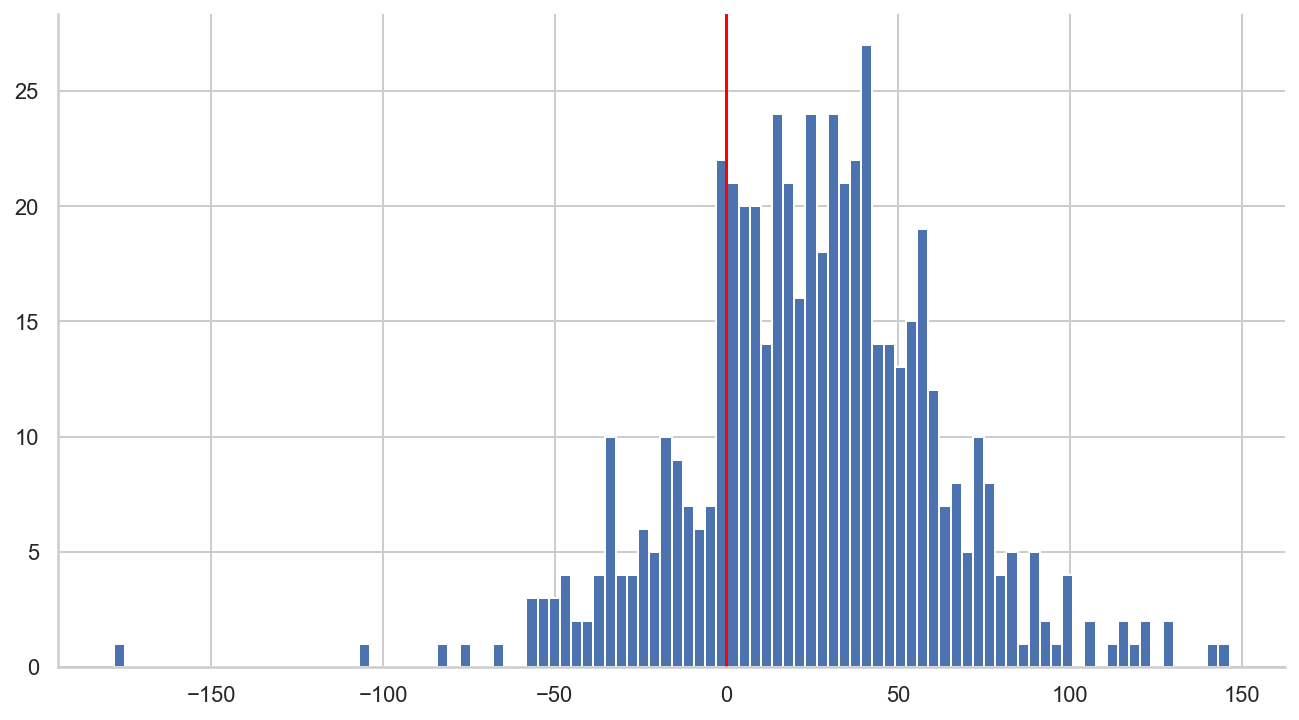

In [ ]:
def single_independence_check(df):
    # We include premature but exclude delayed responses
    no_signal_resp_rt = df.query("(is_stop==0) & (responded==1) & (omission==0)").rt.mean()
    signal_resp_rt = df.query("(is_stop==1) & (responded==1) & (omission==0)").rt.mean()
    independence_check =  no_signal_resp_rt - signal_resp_rt
    return independence_check

def independence_check():
    df = sst_data_getter()
    check = df.groupby('gbe_baseline_index').apply(single_independence_check)
    check_failed = check < 0
    ax = check.hist(bins = 100)
    ax.axvline(x=0, color = "red")
    sns.despine()
    print("In our data, the assumption check failed in %s sessions (%.2f%%)."%(check_failed.sum(), (check_failed.mean()*100)))
    
independence_check()

In [ ]:
def independence_check(s):
    df = dp.decode_ssrt_string(s)
    # We include premature but exclude delayed responses
    no_signal_resp_rt = df.query("(is_stop==0) & (responded==1) & (omission==0)").rt.mean()
    signal_resp_rt = df.query("(is_stop==1) & (responded==1) & (omission==0)").rt.mean()
    independence_check =  no_signal_resp_rt - signal_resp_rt
    return independence_check

## p-stop close to .5

In our data, the assumption check failed in 11 sessions (2.01%).


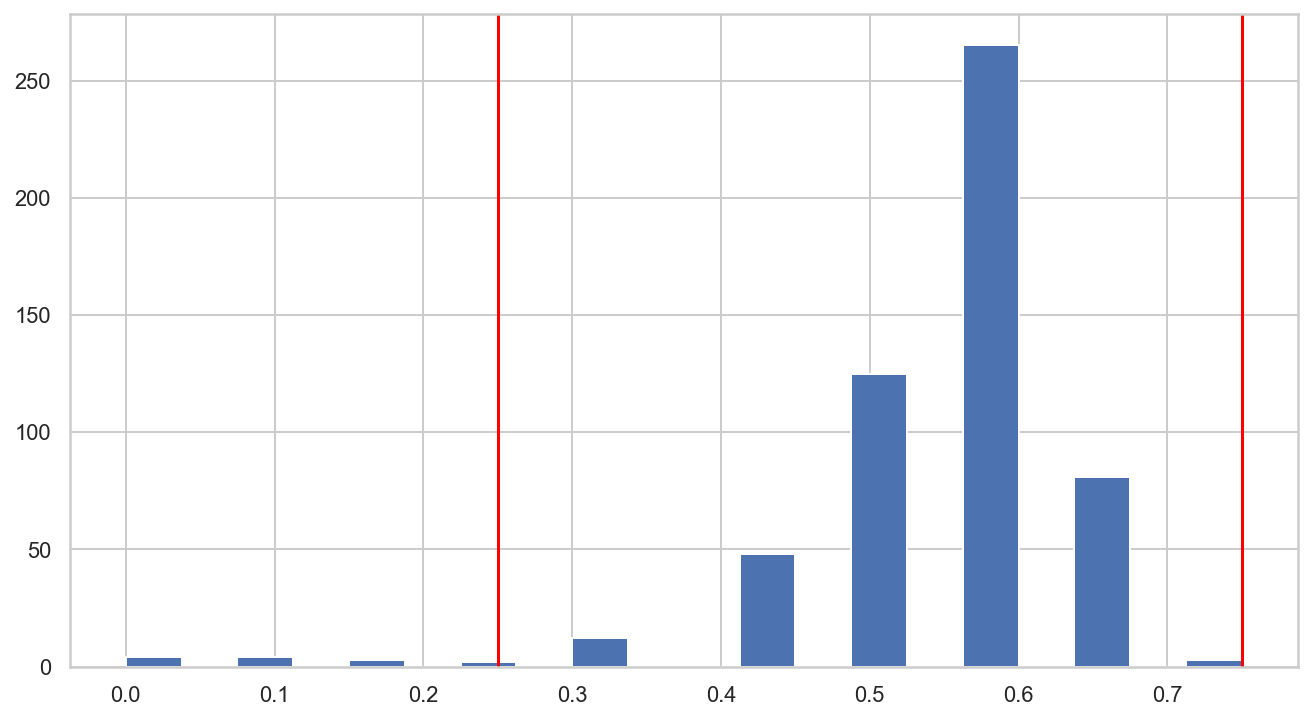

In [ ]:
def single_p_stop_check(df):
    p_resp = df.query("is_stop==1").responded.mean() # p_resp matches
    return 1 - p_resp


def independence_check():
    df = sst_data_getter()
    p_stop = df.groupby('gbe_baseline_index').apply(single_p_stop_check)
    ax = p_stop.hist(bins=20)
    ax.axvline(x=.25, color = "red")
    ax.axvline(x=.75, color = "red")
    check_failed = ((p_stop < .25) | (p_stop > .75))
    print("In our data, the assumption check failed in %s sessions (%.2f%%)."%(check_failed.sum(), check_failed.mean()*100))

    
independence_check()

# Aggregation gold standard: Integration methods
Integration methods are non-parametric methods to estimate SSRTs.  In these methods "the point at which the stop process finishes is estimated by ‘integrating’ the RT distribution and finding the point at which the integral equals p(respond|signal)." (Verbruggen et al., 2019)

<img src="images/horse_race.png" alt="Drawing" style="width: 500px; border-right:10px solid white"/>
<p></p>
<p>All integration methods calculate the mean SSD from all stop trials and find the reaction time associated with p(respond|signal):</p>

In [ ]:
def integration_methods_wrapper(find_nth_rt):
    def wrapper(df):
        # Calculating the average SSD
        signal = df.query("is_stop==1")
        mean_ssd = signal.ssd.mean()
        # The nth RT is calculated differently by the different integration methods
        nth_rt = find_nth_rt(df) # <- This function is defined by different integration methods (see below).
        # Calculating ssrt
        ssrt = nth_rt - mean_ssd
        return ssrt
    return wrapper

# ToDo: This should be moved to utils
def verbruggen_quantile(rts, p_resp):
    # This R-function is taken from the supplementary material of Verbruggen et al. (2019)
    %R nth <- round(quantile(rts, probs = p_resp, type = 6)) -i rts -i p_resp -o nth
    return nth[0]

There are three integration methods, that differ in how they determine the nth RT:

1) Integration with replacement of go omissions (recommended by Verbruggen et al., 2019)
2) Integration with exclusion of go omissions (e.g., Smittenaar et al., 2015)
3) Adjusted p(respond|signal) method (Tannock et al., 1989)

## Integration with replacement of go omissions (ToDo)
This method calculates p(respond|signal) based on the unadjusted probability of responding in stop trials.  Next, it replaces RTs on omission trials with the maximum valid RT. Finally, it finds the nth RT based on all go trials with valid responses (i.e., premature trials and omissions are excluded).

## Integration with exclusion of go omissions
This method calculates p(respond|signal) based on the unadjusted probability of responding in stop trials.  Next, it finds the nth RT based on all go trials with valid responses (i.e., premature trials and omissions are excluded).  This method is used by Smittenaar et al. (2015).

In [ ]:
@integration_methods_wrapper
def integration_without_replacement(df):
    # p_stop is calculated 
    p_resp = df.query("is_stop==1").responded.mean() # p_resp matches
    # We include all valid go RTs (this means we exclude premature and late responses)
    no_signal_resp_rts = df.query("is_stop==0 and accuracy==1").rt
    nth_rt = verbruggen_quantile(no_signal_resp_rts, p_resp)
    return nth_rt

@dp.get_efficiently
def get_integration_without_replacement_ssrts():
    df = sst_data_getter()
    return df.groupby('gbe_baseline_index').apply(integration_without_replacement).to_frame(name = "ssrt_integration_without_replacement")

def test_get_integration_without_replacement_ssrts():
    passed = get_integration_without_replacement_ssrts().mean().iloc[0] == pytest.approx(358, .01)
    assert passed, "Results differ from same analysis on 06.11.21."
    
test_get_integration_without_replacement_ssrts()

## Integration method with adjustment of p(respond|signal) (ToDo)

## Parametric (bayesian) methods (ToDo)
Parametric estimations of SSRTs can be used when the indepndence assumption is not met (e.g., Matzke et al., 2018, 2019).  However, these might require more trials (Note: Perhaps we could use priors based on participant data to compensate for this).

Question: I'm not sure how to interpret this plot: Is "Session" (i.e., "Items"), the systematic effect of session?

# Simplified method for trial level analysis: Mean method

The mean method is generally not recommended as it relies on an p(respond|signal) being exactly 50%; It's also highly biased by the tail of the RT-distribution.  On the other, the mean method might lend itself well to trial-level analyses.  Given that in our data p(respond|signal) is relatively close to 50%, we might therefore still consider the mean method.

In [ ]:
def test():
    df = sst_data_getter().query("gbe_baseline_index==49")[['participant','ssd','rt','accuracy','is_stop']]
    df['rt_ssd'] = (df['ssd']*-1).fillna((df.query("is_stop==0").rt))
    print(df.query("is_stop==0").rt.mean() - df.ssd.mean())
    display(df.mean())
    display(df)
test()

305.7575757575758


ssd         308.333333
rt          616.166667
accuracy      0.406250
is_stop       0.375000
rt_ssd      132.826087
dtype: float64

,participant,ssd,rt,accuracy,is_stop,rt_ssd
1536,b045,NaN,NaN,0,0.0,NaN
1537,b045,300.0,NaN,1,1.0,-300.0
1538,b045,NaN,NaN,0,0.0,NaN
1539,b045,350.0,592.0,0,1.0,-350.0
1540,b045,NaN,769.0,1,0.0,769.0
1541,b045,300.0,533.0,0,1.0,-300.0
1542,b045,250.0,NaN,1,1.0,-250.0
1543,b045,NaN,479.0,0,0.0,479.0
1544,b045,300.0,795.0,0,1.0,-300.0
1545,b045,NaN,NaN,0,0.0,NaN


In [ ]:
def mean_method_ssrt(df):
    return df.query("is_stop==0").rt.mean() - df.ssd.mean()

@dp.get_efficiently
def get_mean_method_ssrts():
    df = sst_data_getter()
    return df.groupby('gbe_baseline_index').apply(mean_method_ssrt).to_frame(name = "ssrt_mean_method")

def test_get_mean_method_ssrts():
    passed = get_mean_method_ssrts(update = True).mean().iloc[0] == pytest.approx(377, .01)
    assert passed, "Results differ from same analysis on 08.11.21."
    
test_get_mean_method_ssrts()

Preparing mean_method_ssrts


# Trial level analyses

## Modelling sessions separately

In [ ]:
def test():
    r_data = sst_data_getter()[['participant','baseline_session','gbe_baseline_index','is_stop','ssd','rt','omission','comission']]
    r_data['ssd_rt'] = (r_data['ssd']*-1).fillna((r_data.query("is_stop==0").rt))
    r_data['ssd_rt'] = r_data['rt'].fillna((r_data.ssd))
    df = r_data
    s1 = df.query('baseline_session == "Session 1"')
    %R m1 = lmer(ssd_rt ~ 1 + (1 + is_stop | participant), data=s1, na.action = na.exclude) -i s1
    %R p1 = ggpredict(m1, terms=c("is_stop","participant[all]"), type="re",ci.lvl = NA) -o p1
    p1a = p1
    p1a.columns = ['is_stop','predicted','participant']
    p1a = p1.set_index(['participant','is_stop']).unstack()
    p1a['ssrt_predicted'] = p1a[('predicted',0.0)] - p1a[('predicted',1.0)]
    display(p1a['ssrt_predicted'].to_frame(name="ssrt_predicted"))
    
test()

,ssrt_predicted
participant,
b001,210.341737
b002,251.017561
b012,265.759044
b013,277.288603
b015,216.270864
...,...
m191,164.682079
m192,228.137439
m193,251.884026


In [ ]:
def get_ssrt_predicted(df):
    s1 = df.query('baseline_session == "Session 1"')
    s2 = df.query('baseline_session == "Session 2"')
    %R m1 = lmer(ssd_rt ~ 1 + (1 + is_stop | participant), data=s1, na.action = na.exclude) -i s1
    %R m2 = lmer(ssd_rt ~ 1 + (1 + is_stop | participant), data=s2, na.action = na.exclude) -i s2
    %R pred_1 <- ggpredict(m1, terms=c("is_stop","participant[all]"), type="re",ci.lvl = NA) -o pred_1
    %R pred_2 <- ggpredict(m2, terms=c("is_stop","participant[all]"), type="re",ci.lvl = NA) -o pred_2
    p1a = pred_1
    p1a.columns = ['is_stop','predicted','participant']
    p1a = p1a.set_index(['participant','is_stop']).unstack()
    p1a['ssrt_predicted'] = p1a[('predicted',0.0)] - p1a[('predicted',1.0)]
    p1a = p1a['ssrt_predicted'].to_frame(name="predicted").reset_index()
    p2a = pred_2
    p2a.columns = ['is_stop','predicted','participant']
    p2a = p2a.set_index(['participant','is_stop']).unstack()
    p2a['ssrt_predicted'] = p2a[('predicted',0.0)] - p2a[('predicted',1.0)]
    p2a = p2a['ssrt_predicted'].to_frame(name="predicted").reset_index()
    p1, p2 = p1a, p2a
    
    #p1.columns = ['participant','predicted','baseline_session']
    #p2.columns = ['participant','predicted','baseline_session']
    p1['baseline_session'] = 'Session 1'
    p2['baseline_session'] = 'Session 2'
    predicted = pd.concat([p1,p2], ignore_index = True)
    # This line is ugly (all it does is bring the data back to the gbe_baseline_index)
    predicted = pd.merge(predicted, df.groupby(['participant','baseline_session'])['gbe_baseline_index'].first().reset_index(), on = ['participant','baseline_session'], how='inner', validate='one_to_many').set_index('gbe_baseline_index')['predicted']
    return predicted


@dp.get_efficiently
def get_predicted_ssrts():
    r_data = sst_data_getter()[['participant','baseline_session','gbe_baseline_index','is_stop','ssd','rt','omission','comission']]
    r_data['ssd_rt'] = (r_data['ssd']).fillna((r_data.query("is_stop==0").rt))
    session_data = session_data_getter()
    session_data.drop(columns = ['initial'], inplace = True)
    r_data['session'] = r_data.baseline_session.apply(lambda x: int(x.split(' ')[1]))
    session_data['ssrt_predicted'] = get_ssrt_predicted(r_data)
    return session_data

get_predicted_ssrts()

Preparing predicted_ssrts


,ssrt_predicted
gbe_baseline_index,
0,331.857706
1,324.619146
2,374.198104
3,295.598738
4,426.499839
...,...
623,342.016020
624,346.633944
625,296.546832


# Correlations between scores

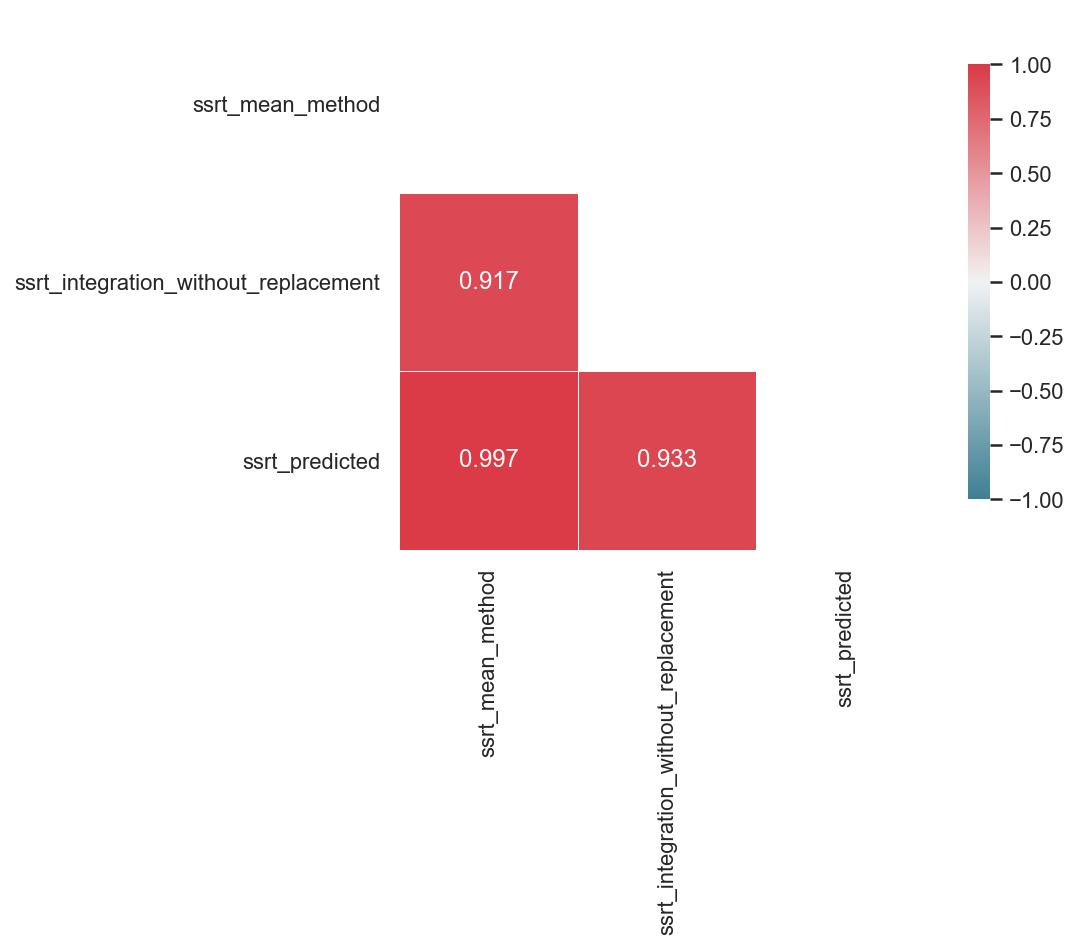

In [ ]:
def show_correlations():
    df = get_mean_method_ssrts().merge(get_integration_without_replacement_ssrts(), left_index = True, right_index = True).merge(get_predicted_ssrts(), left_index = True, right_index = True)
    plotting.correlation_matrix(df, size = (6,8))
show_correlations()

# Explorations